In [5]:
#Our aim is to build a model where we are going to feed an image and corresponding to that image we will get a caption representing that image
###STEPS TO FOLLOW:
#1.DATA COLLECTION = Flicker 8K dataset with 6K training images, 1K validation images and 1K testing images
#2 UNDERSTANDING OF THE DATA
#3 DATA CLEANING
#4 LOADING TRAINING DATASET
#5 DATA PROCESSING ---- IMAGES
#6 DATA PROCESSING ---- CAPTIONS
#7 WORD EMBEDDINGS
#8 MODEL ARCHITECTURE
#9 EVALUATION =  we use "Blue Score" as our evaluation matrix
#IMAGE DATA IS AVAILABLE AT "https://www.kaggle.com/datasets/adityajn105/flickr8k?resource=download"

# **DATA COLLECTION**

In [2]:
import numpy as np    #create matrices and performing some mathematical part
import matplotlib.pyplot as plt #used to display our pictures
import keras
import re
import nltk #for data preprocessing of images
import string
import json
from time import time
import pickle  #used for loading and saving our pre-trained model

#we use tranfer learning technique for feature extraction of images, so we will use RESNET 50 model

from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers import add

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
 # Reading the Description text file

with open(r"/content/drive/MyDrive/Flickr_Data/Flickr_TextData/Flickr8k.token.txt") as filepath:
    captions = filepath.read()
    filepath.close()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'

In [ ]:
captions = captions.split("\n")[:-1]

In [ ]:
len(captions)

40460

In [ ]:
# creating a "descriptions" dictionary  where key is 'img_name' and value is list of captions corresponding to that image_file.
#in this dictionary for every image name we are going to store 5 captions in the form of a list

descriptions = {}

for ele in captions:
    i_to_c = ele.split("\t")  #splitting on the basis of "\t" which is space after that 0th part contain image name and 1st part contain caption
    img_name = i_to_c[0].split(".")[0]
    cap = i_to_c[1]

    if descriptions.get(img_name) == None:
        descriptions[img_name] = []

    descriptions[img_name].append(cap)

In [ ]:
#for example we take one image with name as follows have 5 captions shown in result
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

# **DATA CLEANING**

In [ ]:
#steps we are perfroming in data cleaning
#1 converting every letter into its lowercase
#2 removing all the puntuations, unnecessary numbers or specia characters
#3 removing words whose length is less than or equal to 1

In [ ]:
def clean_text(sample):
    sample = sample.lower()

    sample = re.sub("[^a-z]+"," ",sample)

    sample = sample.split()

    sample = [s for s in sample if len(s)>1]

    sample = " ".join(sample)

    return sample

In [ ]:
#for example
clean_text("My noghsujf si am m cricket101 &8 mphi*&86%%&??,BYs6fajdn 213 q rqu243 boy  32 ewr wO>>J DHD 34  asfb HHGY Gvg HgB   231 123")

'my noghsujf si am cricket mphi bys fajdn rqu boy ewr wo dhd asfb hhgy gvg hgb'

In [ ]:
#performing this data cleaning operation in every captions present in description dictionary
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc_list[i] = clean_text(desc_list[i])

In [ ]:
#sample output after cleaning
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [ ]:
#to avoid the repeatation task of this data cleaning process we are storing this description dictionary so that whenever we want to use we can directly import that description dictionary

# writing clean description to .txt file

f = open("descriptions.txt","w")
f.write( str(descriptions) )
f.close()

In [ ]:
#reading description file

f = open("descriptions.txt", 'r')
descriptions = f.read()
f.close()

json_acceptable_string = descriptions.replace("'", "\"")
descriptions = json.loads(json_acceptable_string)

In [ ]:
#finding the unique vocabulary

vocabulary = set()

for key in descriptions.keys():
    [vocabulary.update(i.split()) for i in descriptions[key]]

print('Vocabulary Size: %d' % len(vocabulary))

Vocabulary Size: 8424


In [ ]:
#creating a vocabulary where we are going to store all the words that have been given in captions
#all words in description dictionary
all_vocab =  [] #creating list containing all the words present in captions and storing

for key in descriptions.keys():
    [all_vocab.append(i) for des in descriptions[key] for i in des.split()]

print('Vocabulary Size: %d' % len(all_vocab))
print(all_vocab[:15])

Vocabulary Size: 373837
['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', 'girl']


In [ ]:
#count the frequency of each word, sort them and discard the words having frequency lesser than threshold value
#here we are trying to remove outliers and uncommon words that are specfice to certian images
#we are considering the words that are used to depict our images quite frequently
import collections


counter= collections.Counter(all_vocab)

dic_ = dict(counter)

threshelod_value = 10  #we are keeping the words which is having threshold value greater than 10

sorted_dic = sorted(dic_.items(), reverse=True, key = lambda x: x[1])
sorted_dic = [x for x in sorted_dic if x[1]>threshelod_value]
all_vocab = [x[0] for x in sorted_dic]

In [ ]:
#atlast we are having no. of frequent words with threshold value > 10 is
len(all_vocab)

1845

# **##DATA_PREPROCESSING**
# **LOADING TRAINING DATA AND TESTING DATA**


In [ ]:
# TrainImagesFile
f = open(r"/content/drive/MyDrive/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
train = f.read()
f.close()

In [ ]:
#splitting and removing ".jpg" from all the texts in that train images text file
train  = [e.split(".")[0] for e in train.split("\n")[:-1]]

In [ ]:
# TestImagesFile
f = open(r"/content/drive/MyDrive/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")
test = f.read()
f.close()

In [ ]:
#splitting and removing ".jpg" from all the texts in that test images text file
test  = [e.split(".")[0] for e in test.split("\n")[:-1]]

In [ ]:
#creating train description dictionary for every image we are going to store corresponding captions to it
#we will create seperatetraining and testing dictionary
train_descriptions = {}  #will contain only names of train images and for these training images we are going to store captions
#for every caption we are going to add start sequence(represents starting of caption) and end sequence(represents ending of caption) to it
for t in train:
    train_descriptions[t] = []
    for cap in descriptions[t]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[t].append(cap_to_append)

In [ ]:
#sample result
train_descriptions['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [ ]:
#after training data we are going to perform data preprocessing of images
#we are using TRANSFER LEARNING TECHNIQUE for data preprocessing
##we are using RESNET50 model for transfer learning techinque,which is basically trained on imagenet dataset which is used for classification into 1000 classes

# **DATA PREPROCESSING - IMAGES**

In [ ]:
#loading our ResNet50 model
model = ResNet50(weights="imagenet", input_shape=(224,224,3))

In [ ]:
#summary of our model
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
#removing last layer as it is basically used for classification into 1000 classes
#Create a new model, by removing the last layer (output layer of 1000 classes) from the resnet50
model_new = Model(model.input, model.layers[-2].output)
#now, we can use this model to extract features from our images

In [ ]:
#loading our images
images = "/content/drive/MyDrive/Flickr_Data/Images"

In [ ]:
#now we have to convert loaded images into array
def preprocess_image(img):
    img = image.load_img(img, target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [ ]:
#using ResNet50 model we had built before for this encode image function and predict the image by making feature vector out of our image
def encode_image(img):
    img = preprocess_image(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape(feature_vector.shape[1],)
    return feature_vector

In [ ]:
#creating encoding train dictionary and call our encode image function and store feature vector out of it
start = time()

encoding_train = {}

for ix, img in enumerate(train):

    img = "/content/drive/MyDrive/Flickr_Data/Images/{}.jpg".format(train[ix])
    encoding_train[img[len(images):]] = encode_image(img)

    if ix%100==0:
        print("Encoding image- "+ str(ix))

print("Time taken in seconds =", time()-start)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 197ms/step
Encoding image- 1100
1/1 [==============================] - 0s 338ms/step
Encoding image- 1200
1/1 [==============================] - 0s 235ms/step
Encoding image- 1300
1/1 [==============================] - 0s 219ms/step
Encoding image- 1400
1/1 [==============================] - 0s 211ms/step
Encoding image- 1500
1/1 [==============================] - 0s 343ms/step
Encoding image- 1600
1/1 [==============================] - 0s 198ms/step
Encoding image- 1700
1/1 [==============================] - 0s 210ms/step
Encoding image- 1800
1/1 [==============================] - 0s 371ms/step
Encoding image- 1900
1/1 [==============================] - 0s 206ms/step
Encoding image- 2000
1/1 [==============================] - 0s 204ms/step
Encoding image- 2100
1/1 [==============================] - 0s 221ms/step
Encoding image- 2200
1/1 [==============================] - 0s 200ms/step
Encoding

In [ ]:
#storing our encoding train dictionary for not performing this task again
with open("/content/drive/MyDrive/Flickr_Data/encodin_train_features.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [ ]:
#loading same dictionary again
import pickle as pkl
with open("/content/drive/MyDrive/Flickr_Data/encodin_train_features.pkl","rb") as f:
    encoding_train=pkl.load(f)

In [ ]:
#encoding of test images
start = time()

encoding_test = {}

for ix, img in enumerate(test):

    img = "/content/drive/MyDrive/Flickr_Data/Images/{}.jpg".format(test[ix])
    encoding_test[img[len(images):]] = encode_image(img)

    if ix%100==0:
        print("Encoding image- "+ str(ix))

print("Time taken in seconds =", time()-start)

1/1 [==============================] - 0s 208ms/step
Encoding image- 0
1/1 [==============================] - 0s 212ms/step
Encoding image- 100
1/1 [==============================] - 0s 192ms/step
Encoding image- 200
1/1 [==============================] - 0s 202ms/step
Encoding image- 300
1/1 [==============================] - 0s 213ms/step
Encoding image- 400
1/1 [==============================] - 0s 208ms/step
Encoding image- 500
1/1 [==============================] - 0s 191ms/step
Encoding image- 600
1/1 [==============================] - 0s 199ms/step
Encoding image- 700
1/1 [==============================] - 0s 207ms/step
Encoding image- 800
1/1 [==============================] - 0s 209ms/step
Encoding image- 900
1/1 [==============================] - 0s 209ms/step
Time taken in seconds = 379.1238703727722


In [ ]:
#storing our encoding test dictionary for not performing this task again
with open("/content/drive/MyDrive/Flickr_Data/encoded_test_features.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [ ]:
#loading same dictionary again
with open("/content/drive/MyDrive/Flickr_Data/encoded_test_features.pkl","rb") as f:
    encoding_test=pkl.load(f)

In [ ]:
# Load the train images features from disk

with open("/content/drive/MyDrive/Flickr_Data/encodin_train_features.pkl", "rb") as encoded_pickle:
    encoding_train = pickle.load(encoded_pickle)

In [ ]:
# Load the test images features from disk

with open("/content/drive/MyDrive/Flickr_Data/encoded_test_features.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

In [ ]:
encoding_test

{'/3385593926_d3e9c21170.jpg': array([0.33316922, 0.38347757, 0.0725343 , ..., 0.90832144, 0.35600492,
        1.0914084 ], dtype=float32),
 '/2677656448_6b7e7702af.jpg': array([0.29456007, 0.09500372, 0.7013537 , ..., 0.01996758, 0.29111916,
        0.10959236], dtype=float32),
 '/311146855_0b65fdb169.jpg': array([0.01133581, 0.087804  , 0.14325373, ..., 0.03005865, 1.1857138 ,
        0.06954608], dtype=float32),
 '/1258913059_07c613f7ff.jpg': array([0.04770468, 1.4354502 , 0.10770204, ..., 0.13344447, 0.1150556 ,
        2.0496244 ], dtype=float32),
 '/241347760_d44c8d3a01.jpg': array([0.06552815, 6.6828303 , 0.31763455, ..., 0.06200397, 0.03742849,
        0.04522505], dtype=float32),
 '/2654514044_a70a6e2c21.jpg': array([1.9562047 , 0.04316797, 0.11143825, ..., 0.02008316, 0.6832548 ,
        0.43294114], dtype=float32),
 '/2339106348_2df90aa6a9.jpg': array([0.08876368, 1.1927909 , 0.0767652 , ..., 0.01899936, 0.13417554,
        0.13799472], dtype=float32),
 '/256085101_2c2617c5d

# **DATA PREPROCESSING - CAPTIONS**

In [ ]:
#creating dictionaries of "word to index" and "index to word" to map every word to our captions to certian number
#this because we can't feed our words into our model directly
#we are converting every word to an index and going to use those numbers for feeding it into our model and get predictions


ix = 1
word_to_idx = {}
idx_to_word = {}  #dictionary for converting those numbers back to words after result from our model

for e in all_vocab:
    word_to_idx[e] = ix
    idx_to_word[ix] = e
    ix +=1

In [ ]:
#need to add these 2 words as well

word_to_idx['startseq'] = 1846
word_to_idx['endseq'] = 1847

idx_to_word[1846] = 'startseq'
idx_to_word[1847] = 'endseq'

In [ ]:
#vocab_size is total vocabulary len +1 because we will append 0's as well.

vocab_size = len(idx_to_word)+1
print(vocab_size)

1848


In [ ]:
all_captions_len = []

for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        all_captions_len.append(len(cap.split()))

max_len = max(all_captions_len)
print(max_len)

35


# **DATA PREPROCESSING USING "GENERATOR FUNCTION"**

In [ ]:
#PREDICTION OF OUR CAPTION
#feeding our data into batches as it is huge
#predictions were done in the form like, we are going to feed our image vector and first word into our model and that first word will start sequence
#after that, model is going to predict second word, this word we are going to add to start sequence and we will again feed the image vector
#the partial caption, that is start sequence plus predicted wordinto a model and model will predict the third word
#thos process will go on untill we reach our maximum length or we reach the end sequence
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, num_photos_per_batch):

    X1, X2, y = [], [], []

    n=0

    while True:

        for key, desc_list in train_descriptions.items():
            n +=1

            photo = encoding_train[key]

            for desc in desc_list:

                seq = [ word_to_idx[word] for word in desc.split() if word in word_to_idx]

                for i in range(1,len(seq)):

                    in_seq = seq[0:i]
                    out_seq = seq[i]

                    in_seq = pad_sequences([in_seq], maxlen=max_len, value=0, padding='post')[0]

                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                u = np.array(X1)
                v = np.array(X2)
                w = np.array(y)
                yield ([u,v],w)
                X1, X2, y = [], [], []
                n=0

# **WORD EMBEDDING**

In [ ]:
#we need to convert every word into our 50 words long vector

In [ ]:
#we are going to use "GLOVE VECTOR" for word embedding
f = open("/content/drive/MyDrive/Flickr_Data/glove_6B_50d.txt", encoding='utf8')

In [ ]:
#as we cannot feed our data directly, we need to use pretrained glove model for it
embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float")

    embedding_index[word] = coefs

f.close()

# **CONVERTING WORDS INTO VECTORS DIRECTLY**
##**#EMBEDDING** **LAYER** **OUTPUT**

In [ ]:
 #creating embedding dictionary to get embedded output function where embeded dimensions will be 50 and no. of rows will be vocabulary size
def get_embedding_output():

    emb_dim = 50
    embedding_output = np.zeros((vocab_size,emb_dim))

    for word, idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)

        if embedding_vector is not None:
            embedding_output[idx] = embedding_vector

    return embedding_output


embedding_output = get_embedding_output()

In [ ]:
#shape of our embedding matrix
embedding_output.shape
#here 1848 is our vocabulary size

(1848, 50)

# **MODEL ARCHITECTURE**

In [ ]:
#model architecture is done in 2 parts
####1 is for images
####2 is for partial caption model
#we will use functional API in keras,  which allows us to create merge models

In [ ]:
#in our first part, image feature extractor model
###we are going to pass image feature vector of length 2048
###then we will use dropout layer which is used to avoid overfitting
###then we will add a dense layer with size 256 and ReLU as an activation function

input_img_fea = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_fea)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [ ]:
#in ou second part, partial caption sequence model
###we are going to pass sequence of indices of partial caption
###after that we are going to add an embedding layer
###then we are going to add dropout layer
###at the end we will add LSTM layer
input_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [ ]:
#output of LSTM and dense layer is of same shape, so we can add these 2
#after this, we will add a dense layer and finally create an output layer with "softmax activation function"
decoder1 = add([inp_img2 , inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Merge 2 networks
model = Model(inputs=[input_img_fea, input_cap], outputs=outputs)


#it is going to predict probabilities of each word and we need to select word with max. probability and add it to our sequence

In [ ]:
#our model summary
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 35)]                 0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 35, 50)               92400     ['input_6[0][0]']             
                                                                                                  
 dropout_2 (Dropout)         (None, 2048)                 0         ['input_5[0][0]']             
                                                                                            

In [ ]:
#adding our embedding layer that we prepared earlier(use our embedding matrix prepared from glove vector)
model.layers[2].set_weights([embedding_output])
model.layers[2].trainable = False  #we need to freeze our pretrained embedding layer before training so that it doesn't get updated during back propagation

In [ ]:
#weights of model eill be updated through back propagation algorithm and model will learn to ouput a word where we will give our image vector and a partial caption

In [ ]:
#compilation of our model using loss as categorical cross entropy and adam optimizer
model.compile(loss="categorical_crossentropy", optimizer="adam")

# **TRAIN OUR MODEL**

In [ ]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [ ]:
 #we are going to call "data generator function" and with the help of it we will output in "generator"
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, num_photos_per_batch):
    for key in train_descriptions.keys():
        print(f"Processing key: {key}")
        if key in encoding_train:
          for i in range(epochs):
            generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, number_pics_per_bath)
            model.fit(generator, epochs=10, steps_per_epoch=steps, verbose=1)
            model.save('/content/drive/MyDrive/Flickr_Data/model_new_' + str(i) + '.h5') #saving our model with whatever best accuracy it will give

In [ ]:
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [ ]:
#loading the model which got best accuracy
model = load_model("/content/drive/MyDrive/Flickr_Data/model_9.h5")

# **PREDICTIONS**

In [ ]:
#creating a function to predict captions
#in this we will feed the start sequence word after that we are going to use pad sequence(for unformity purposes)
#we don't have different lengths, so we are going to add zeros at the end and length of the caption should be same
#we use 35 because it is the max. length
def predict_caption(photo):
    in_text = "startseq"

    for i in range(max_len): #this will perform untill we reach n sequence or we reach max. length
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')
#we will provide feature vector of our images and apartial caption and it will give probability of every word in vocab


        ypred =  model.predict([photo,sequence])
        #we will choosethe word with max. probability using "argmax"
        ypred = ypred.argmax()
        #the predictions will be in the form of indices, so we need to convert those indices into words
        #this predicted word will be added to in_text
        word = idx_to_word[ypred]
        in_text+= ' ' +word

        if word =='endseq':
            break


    final_caption =  in_text.split()
     #for final caption we need to remove start sequence and end sequence
     #after removing it we will get final caption
    final_caption = final_caption[1:-1]

    final_caption = ' '.join(final_caption)

    return final_caption

In [ ]:
img_path='/content/drive/MyDrive/Flickr_Data/Images/'

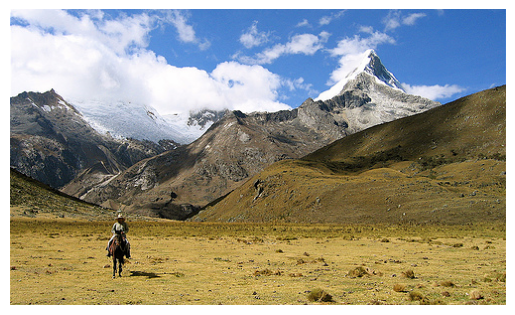

1/1 [==============================] - 1s 516ms/step
two people are walking on top of mountain


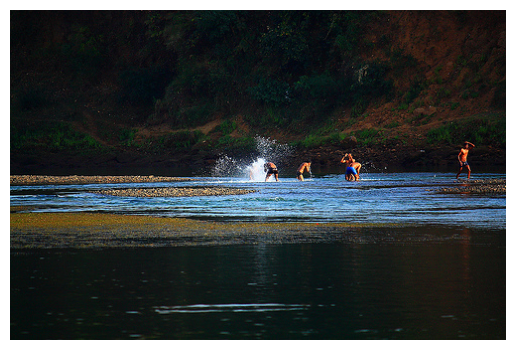

1/1 [==============================] - 0s 273ms/step
man is in the water


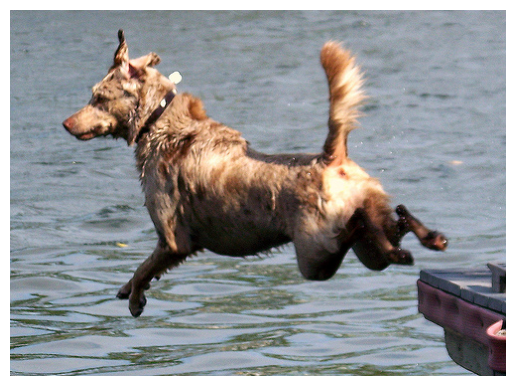

1/1 [==============================] - 0s 275ms/step
two dogs are running through the water


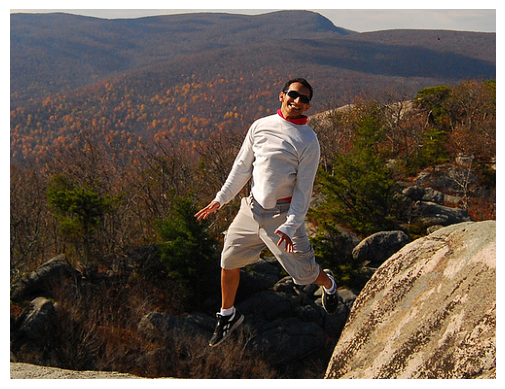

1/1 [==============================] - 0s 289ms/step
man in white shirt and white shorts is standing on rock overlooking valley


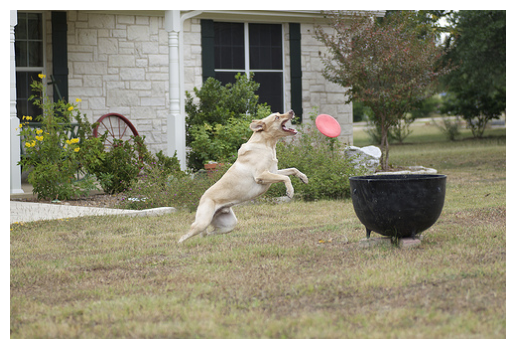

1/1 [==============================] - 0s 295ms/step
dog is jumping up in the air


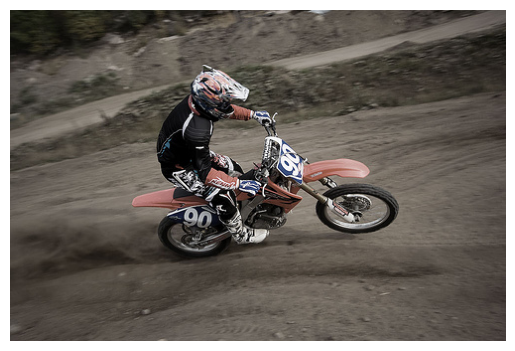

1/1 [==============================] - 0s 314ms/step
man on motorcycle riding his bike on the track


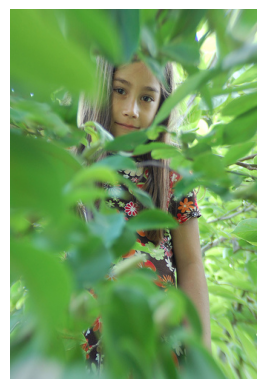

1/1 [==============================] - 0s 375ms/step
little girl in yellow shirt is holding onto child in the grass


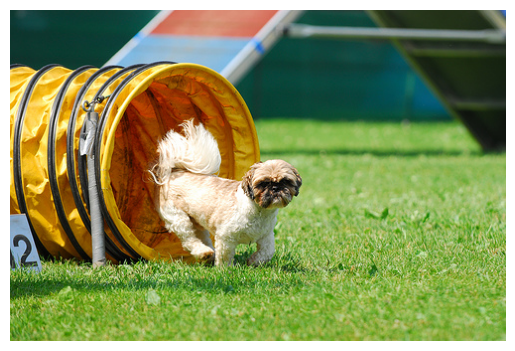

1/1 [==============================] - 0s 275ms/step
dog jumping over hurdle


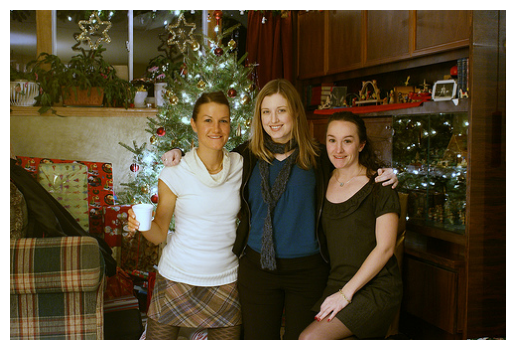

1/1 [==============================] - 0s 293ms/step
woman in purple shirt and black shirt and woman in black dress are standing in front of some trees


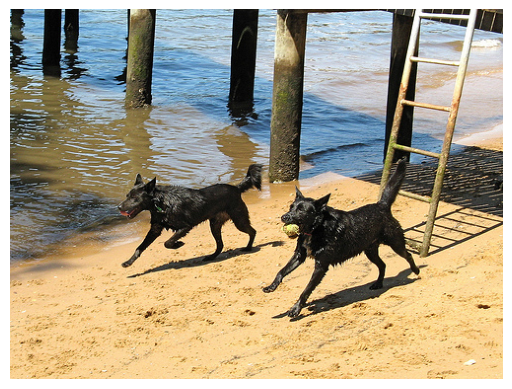

1/1 [==============================] - 0s 418ms/step
two dogs are running on the beach


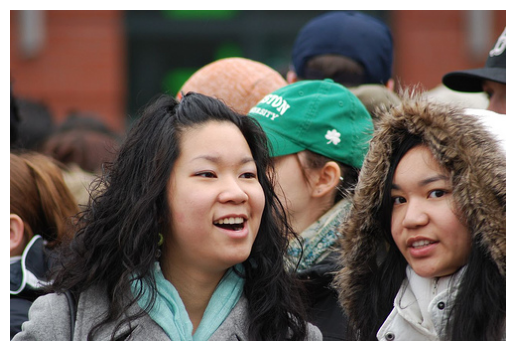

1/1 [==============================] - 1s 605ms/step
woman with an animal


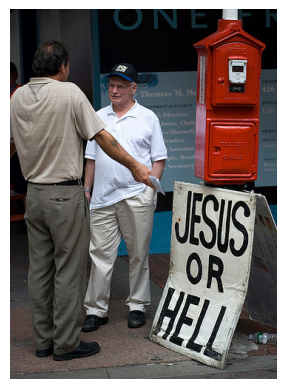

1/1 [==============================] - 1s 555ms/step
man in blue shirt and tie is walking on the street


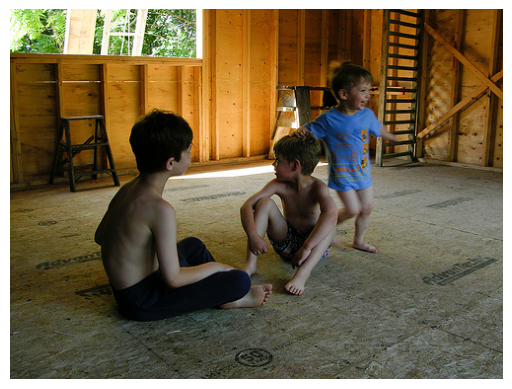

1/1 [==============================] - 0s 322ms/step
group of people are standing in front of window


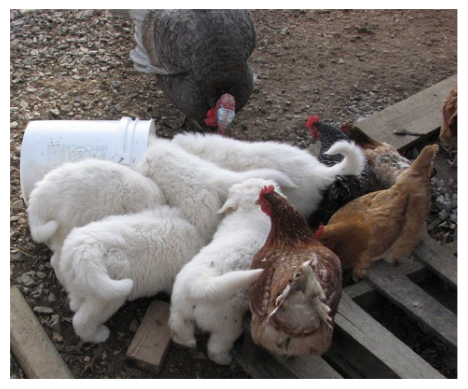

1/1 [==============================] - 0s 397ms/step
two dogs are tied around on the corner of wooden fence


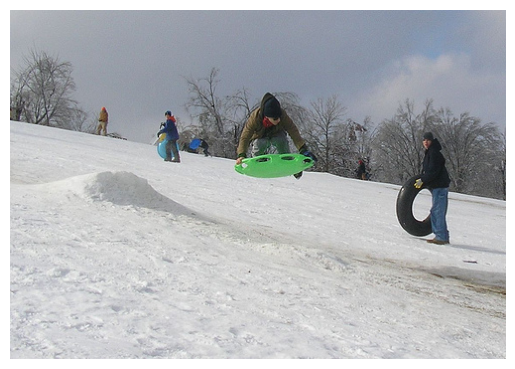

1/1 [==============================] - 0s 303ms/step
man in red shirt is riding on the snow


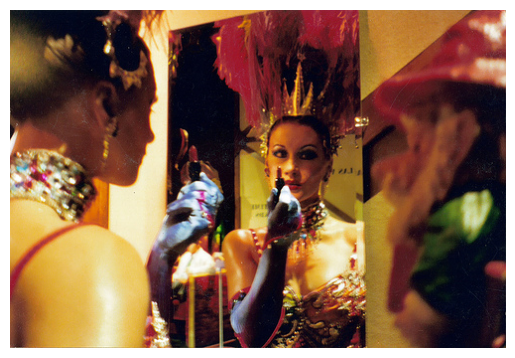

1/1 [==============================] - 0s 300ms/step
crowd of people are sitting in crowd of people


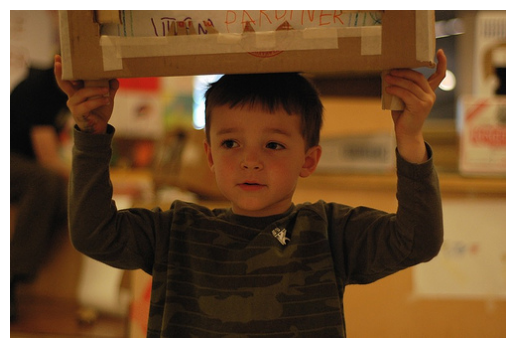

1/1 [==============================] - 0s 326ms/step
boy in blue shirt and cast hair sticking on her head


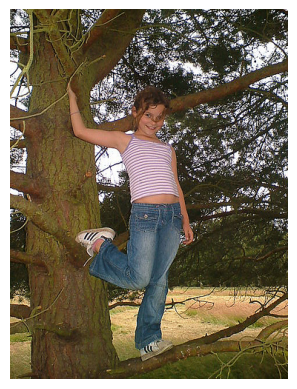

1/1 [==============================] - 0s 284ms/step
boy in plaid shirt and sandals is on tree stump


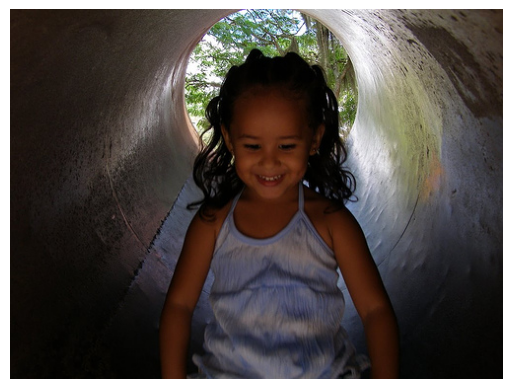

1/1 [==============================] - 1s 925ms/step
woman in sunglasses is sitting on the phone


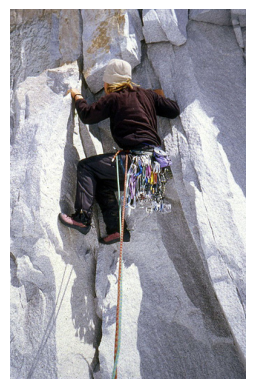

1/1 [==============================] - 1s 566ms/step
man in red shirt is standing on concrete wall


In [ ]:
#predicting caption for different images randomly
 #randomly selecting 20 images from 1000 test images and feed it into predict_caption function
for i in range(20):
    rn =  np.random.randint(0, 1000)
    img_name = list(encoding_test.keys())[rn]
    photo = encoding_test[img_name].reshape((1,2048))

    i = plt.imread(img_path+img_name)
    plt.imshow(i)
    plt.axis("off")
    plt.show()

    caption = predict_caption(photo)

    print(caption)

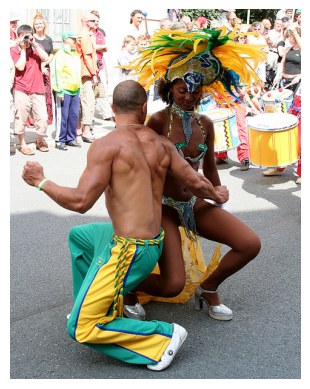

1/1 [==============================] - 0s 287ms/step
two girls in red and white dresses are playing with fireworks


In [ ]:
img_name = list(encoding_test.keys())[2]
photo = encoding_test[img_name].reshape((1,2048))

i = plt.imread(img_path+img_name)
plt.imshow(i)
plt.axis("off")
plt.show()

caption = predict_caption(photo)
descriptions
print(caption)

In [ ]:
#for evaluation of our matrix, we will use BLEU score(Bilingual Evluation Understudy Score)
#it is a metrics for evaluating a generated sentense by keeping a reference sentense

import nltk
BLEUscore = nltk.translate.bleu_score.sentence_bleu([descriptions], hypothesis)
print(BLEUscore)

0


In [ ]:
#in our case, reference sentence are the 5 captions present in every image
##############generated sentence is the caption predicted by our model
for i in range(5):
    reference=descriptions[img_name][i]
    hypothesis=caption
    BLEUscore += nltk.translate.bleu_score.sentence_bleu([reference], hypothesis)
print(BLEUscore/5)

KeyError: ignored

In [ ]:
reference2=reference.split()
print(reference2)

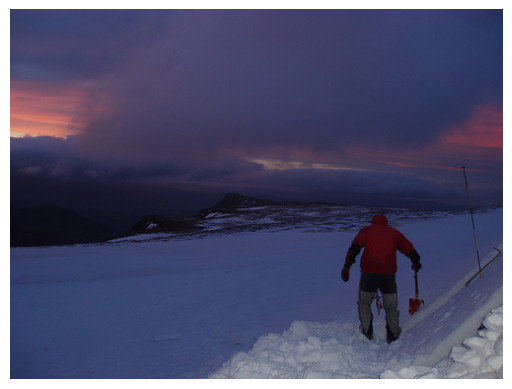

1/1 [==============================] - 1s 583ms/step


KeyError: ignored

In [ ]:
for i in range(20):
    rn =  np.random.randint(0, 1000)
    img_name = list(encoding_test.keys())[rn]
    photo = encoding_test[img_name].reshape((1,2048))

    i = plt.imread(img_path+img_name)
    plt.imshow(i)
    plt.axis("off")
    plt.show()

    caption = predict_caption(photo)

#     for i in range(5):
    BLEUscore=0
    reference1=descriptions[img_name][0].split()
    reference2=descriptions[img_name][1].split()
    reference3=descriptions[img_name][2].split()
    reference4=descriptions[img_name][3].split()
    reference5=descriptions[img_name][4].split()
    hypothesis=caption.split()
    BLEUscore1 = nltk.translate.bleu_score.corpus_bleu([[reference1,reference2,reference3,reference4,reference5]], [hypothesis], weights=(1, 0, 0, 0))
    BLEUscore2 = nltk.translate.bleu_score.corpus_bleu([[reference1,reference2,reference3,reference4,reference5]], [hypothesis], weights=(0.5, 0.5, 0, 0))
    BLEUscore3 = nltk.translate.bleu_score.corpus_bleu([[reference1,reference2,reference3,reference4,reference5]], [hypothesis], weights=(0.33, 0.33, 0.33, 0))
    BLEUscore4 = nltk.translate.bleu_score.corpus_bleu([[reference1,reference2,reference3,reference4,reference5]], [hypothesis], weights=(0.25, 0.25, 0.25, 0.25))

    print("Cumulative 1-gram:%.3f"%BLEUscore1)
    print("Cumulative 2-gram:%.3f"%(BLEUscore2))
    print(descriptions[img_name][0])
    print(caption)